<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%204/nodulos_pulmon_EJERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes convolucionales (CNNs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de malignidad en nódulos pulmonares**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

In [2]:
COLAB = True

In [3]:
# Base de datos y kernel de lectura y visualización de la base de datos obtenidos de:
#
# https://www.kaggle.com/kmader/lungnodemalignancy

import cv2 # pip install opencv-python
import os
import numpy as np
from tqdm import tqdm # pip install tqdm
import matplotlib.pyplot as plt
#from skimage.util.montage import montage2d # pip install scikit-image
import h5py
import urllib
from sklearn.metrics import confusion_matrix

%matplotlib inline

## **Carga de datos**

In [4]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1Ai3qxn-N-9T5wTblXNgVTIHlvwrvIXXg',
                                        dest_path='./all_patches.hdf5')

with h5py.File('all_patches.hdf5', 'r') as luna_h5:
    all_slices  = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('shape of all_slices:', all_slices.shape)
    print('shape of classes:   ', all_classes.shape)

shape of all_slices: (6691, 64, 64)
shape of classes:    (6691, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [5]:
!ls

all_patches.hdf5  sample_data


In [6]:
np.unique(all_classes)

array([0., 1.])

In [7]:
def mi_montage2d(data):
    n = len(data)
    lado = int(np.ceil(np.sqrt(n)))
    alto1, ancho1 = data.shape[1:]
    aux = np.zeros((lado*alto1, lado*ancho1))
    for i,image in enumerate(data):
        row = i // lado
        col = i % lado
        aux[(row*alto1):((row+1)*alto1), (col*ancho1):((col+1)*ancho1)] = image
    return aux

In [8]:
def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)

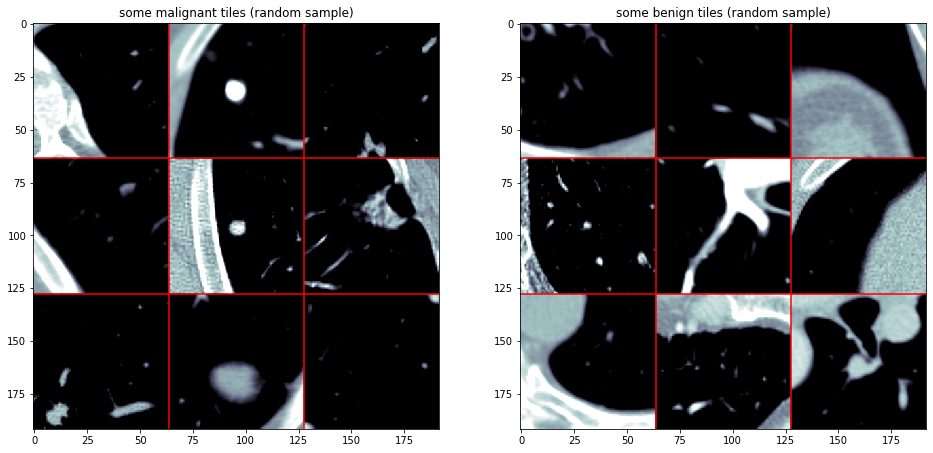

In [9]:
size = 9
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
#plt_args = dict(cmap = 'bwr', vmin = -600, vmax = 300)
ax1.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==1)[0],size=size)]), **plt_args)
ax1.set_title('some malignant tiles (random sample)')
draw_borders(ax1, size, all_slices.shape[1], all_slices.shape[2], 'r')

ax2.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==0)[0],size=size)]), **plt_args)
ax2.set_title('some benign tiles (random sample)')
draw_borders(ax2, size, all_slices.shape[1], all_slices.shape[2], 'r');

## **Partición y reformateo de datos**

Partiremos los datos en bases de datos de entrenamiento y validación. Recodificaremos la clase con la técnica one-hot.
Se estandarizarán los datos de la imagen.

In [10]:
all_slices.shape

(6691, 64, 64)

In [11]:
print(all_slices.min(), all_slices.max(), all_slices.mean(), all_slices.std())

-3024.0 3071.0 -588.6012 407.58652


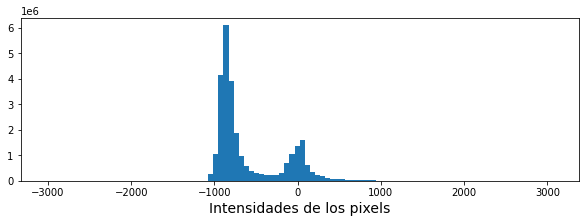

In [12]:
plt.figure(figsize=(10,3))
plt.hist(all_slices.reshape(-1), bins=100) #, density=True)
plt.xlabel('Intensidades de los pixels', fontsize=14)
plt.show()

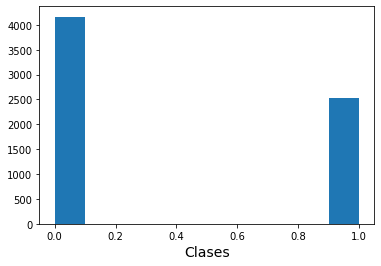

[0. 1.]
[4165 2526]


In [13]:
plt.hist(all_classes)
plt.xlabel('Clases', fontsize=14)
plt.show()

unicos, counts = np.unique(all_classes, return_counts=True)
print(unicos)
print(counts)

In [14]:
prioris_clases = counts / sum(counts)

In [15]:
print(prioris_clases.round(2))

[0.62 0.38]


In [16]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

#X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)
X_vec = np.expand_dims(all_slices,-1)
print(all_slices.shape)
X_vec.shape

(6691, 64, 64)


(6691, 64, 64, 1)

In [17]:
y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

mean_train = np.mean(X_train)
std_train  = np.std(X_train)

X_train = (X_train - mean_train) / std_train
X_test  = (X_test  - mean_train) / std_train

In [18]:
import pickle

with open('mi_fichero.b', 'wb') as f:
    pickle.dump(mean_train, f)
    pickle.dump(std_train, f)

In [19]:
# En explotación:
with open('mi_fichero.b', 'rb') as f:
    a = pickle.load(f)
    b = pickle.load(f)

In [20]:
print(mean_train, std_train)
print(a,b)

-589.3111 407.19113
-589.3111 407.19113


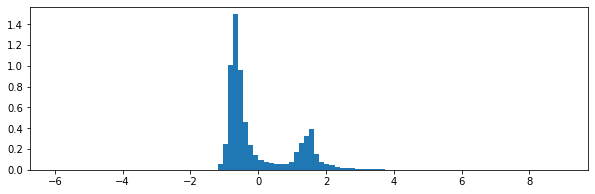

In [21]:
plt.figure(figsize=(10,3))
plt.hist(X_train.reshape(-1), bins=100, density=True)
plt.show()

## **Modelo Dummy (baseline)**

In [22]:
np.shape(y_train)

(5018, 2)

In [23]:
X_tr = np.zeros((np.shape(X_train)[0], np.shape(X_train)[1]*np.shape(X_train)[2]))
for i in range(np.shape(X_train)[0]):
    X_tr[i] = X_train[i].flatten()
X_te = np.zeros((np.shape(X_test)[0], np.shape(X_test)[1]*np.shape(X_test)[2]))
for i in range(np.shape(X_test)[0]):
    X_te[i] = X_test[i].flatten()

print("X_train shape:", np.shape(X_train))
print("X_tr shape:   ", np.shape(X_tr))
print("X_test shape: ", np.shape(X_test))
print("X_te shape:   ", np.shape(X_te))

X_train shape: (5018, 64, 64, 1)
X_tr shape:    (5018, 4096)
X_test shape:  (1673, 64, 64, 1)
X_te shape:    (1673, 4096)


In [24]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_tr, np.argmax(y_train,1))
print('Train accuracy:', clf.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', clf.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.6225587883618972
Test accuracy : 0.6222355050806934


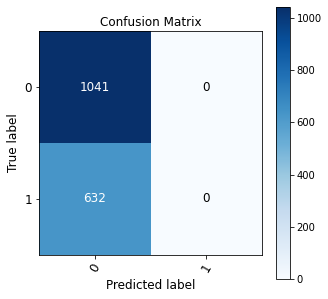

In [25]:
try:
    from scikitplot.metrics import plot_confusion_matrix
except:
    !pip install scikit-plot
    from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test.argmax(1), clf.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1041
           1       0.00      0.00      0.00       632

    accuracy                           0.62      1673
   macro avg       0.31      0.50      0.38      1673
weighted avg       0.39      0.62      0.48      1673



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


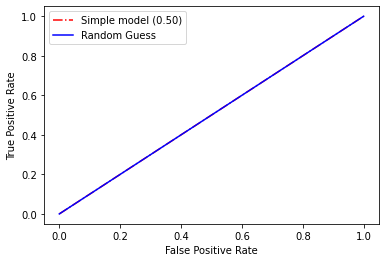

In [26]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            clf.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), clf.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Modelo shallow: regresión logística**

In [27]:
X_train.shape

(5018, 64, 64, 1)

In [28]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()
model2.fit(X_tr, np.argmax(y_train,1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
print('Train accuracy:', model2.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', model2.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.8848146671980869
Test accuracy : 0.7537358039450089


In [30]:
np.argmax(y_test,1)

array([1, 0, 1, ..., 1, 1, 0])

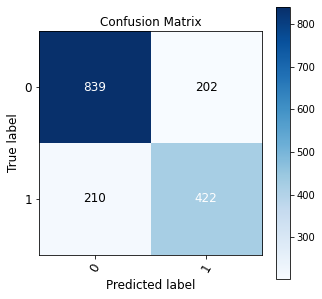

In [31]:
plot_confusion_matrix(y_test.argmax(1), model2.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1041
           1       0.68      0.67      0.67       632

    accuracy                           0.75      1673
   macro avg       0.74      0.74      0.74      1673
weighted avg       0.75      0.75      0.75      1673



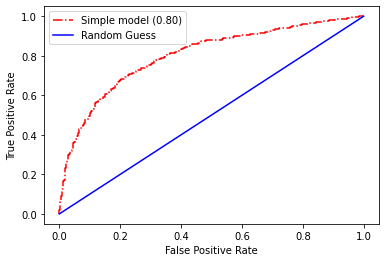

In [32]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), model2.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

# **Definición de la arquitectura CNN**

Entrenaremos el modelo desde cero. Otra posibilidad es utilizar modelos pre entrenados (transfer learning).

In [33]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras import regularizers
from keras.losses import binary_crossentropy
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [34]:
print("X_train shape:", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_test shape: ", np.shape(y_test))

X_train shape: (5018, 64, 64, 1)
X_test shape:  (1673, 64, 64, 1)
y_train shape: (5018, 2)
y_test shape:  (1673, 2)


In [35]:
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [36]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [37]:
X_tr.shape

(5018, 4096)

In [38]:
X_train.shape

(5018, 64, 64, 1)

In [39]:
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

In [40]:
y_train.shape

(5018, 2)

In [41]:
num_classes = 2

In [116]:
from keras.layers import AveragePooling2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import regularizers

In [119]:
# Arquitectura de la red
# Rellenar arquitectura:

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=input_shape, activation='relu', kernel_regularizer=regularizers.L2(0.1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.6))
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=input_shape, activation='relu', kernel_regularizer=regularizers.L2(0.1)))
#model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.6))
model.add(AveragePooling2D())

#model.add(BatchNormalization())

model.add(Flatten())
#model.add(GlobalAveragePooling2D()) #calcula la actividad promedio de los mapas de características que le llegan
#model.add(Dropout(0.7))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 60, 60, 32)        832       
_________________________________________________________________
batch_normalization_33 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
batch_normalization_34 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 13, 13, 32)      

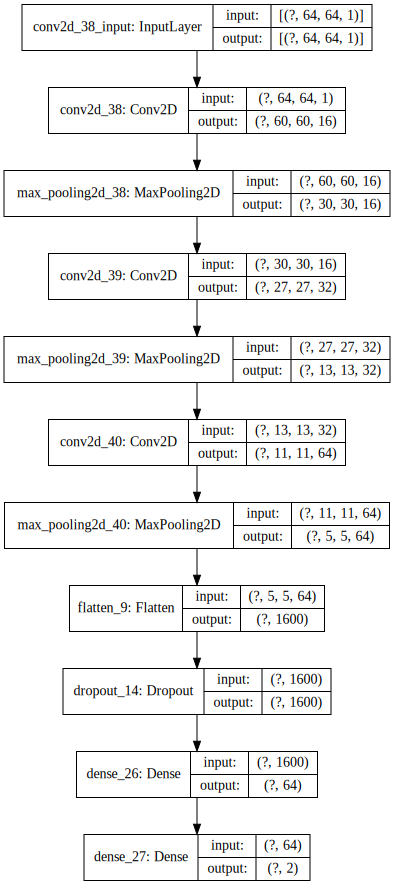

In [97]:
# graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=72
                 ).create(prog='dot', format='svg'))

# **Entrenamiento del modelo CNN**

In [122]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_acc)), 100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.legend(['entrenamiento', 'validacion'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [123]:
acum_tr_acc = []
acum_val_acc = []

In [124]:
from IPython.display import clear_output

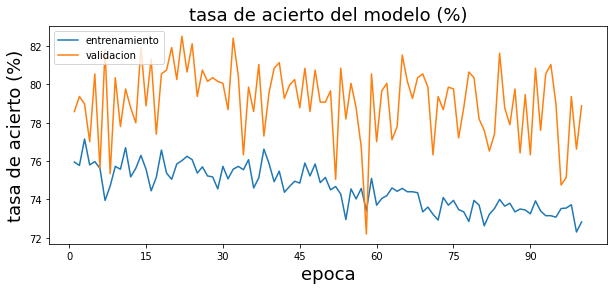

In [125]:
LOAD_MODEL = False

Ntr = 4000

epochs = 100
batch_size = 16

X_tr  = X_train[:Ntr]
y_tr  = y_train[:Ntr]
X_val = X_train[Ntr:]
y_val = y_train[Ntr:]

if not LOAD_MODEL:
    filepath="model_current_best_v2.h5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') # graba sólo los que mejoran en validación
    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        history = model.fit(X_tr, y_tr,
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=1,
                            validation_data=(X_val, y_val))
        
        acum_tr_acc = acum_tr_acc + history.history['accuracy']
        acum_val_acc = acum_val_acc + history.history['val_accuracy']
        
        if len(acum_tr_acc) > 1:
            clear_output()
            grafica_entrenamiento(acum_tr_acc, acum_val_acc)

# **Resultados obtenidos por el modelo CNN**

In [99]:
if LOAD_MODEL:
    if COLAB:
        urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1UKpxwZsfPAp0kHywBucwWBtkxYAXy0lq",
                                   "modelo_entrenado.h5")
    model = load_model('./modelo_entrenado.h5')
else:
    model = load_model('model_current_best_v2.h5')

In [100]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 60, 60, 16)        416       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 27, 27, 32)        8224      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)            

In [101]:
score_tr = model.evaluate(X_tr, y_tr, verbose=0)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model.evaluate(X_val, y_val, verbose=0)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

Train loss    : 0.0024116002023220062
Train accuracy: 0.999750018119812
Val loss    : 0.3064034581184387
Val accuracy: 0.9312376976013184
Test loss     : 0.2993593215942383
Test accuracy : 0.9175134301185608


In [ ]:
model.predict(X_test[:5])

In [ ]:
umbral_decision_maligno = 0.5 # 0.4, 0.3, 0.2 ...

In [ ]:
alarmas = 1*(model.predict(X_test)[:,1]>umbral_decision_maligno)
alarmas

In [ ]:
clases_test = y_test.argmax(1) # clase real test

In [ ]:
confusion_matrix(clases_test, alarmas)

In [ ]:
# en el siguiente cálculo y en adelante es equivalente
# a asumir que umbral_decision_maligno = 0.5
plot_confusion_matrix(y_test.argmax(1), model.predict(X_test).argmax(1),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(clases_test, y_pred))

In [ ]:
fpr, tpr, thresholds = roc_curve(clases_test, y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# **Análisis de los pesos de la primera capa**

In [ ]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

In [ ]:
weights[0][:,:,0,0]

In [ ]:
# kernels de la primera capa

nfilters = weights[0].shape[3]
lado = int(np.ceil(np.sqrt(nfilters)))
plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(weights[0]).max()

for i in range(nfilters):
    kernel = weights[0][:,:,0,i]
    plt.subplot(lado,lado,i+1)
    plt.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('kernel %d' % i)


In [ ]:
capa = 0 # 4
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[capa].output)
intermediate_layer_model.summary()
SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [ ]:
id_imagen = 1
imagen = X_test[id_imagen,:,:,0]
salidas_capa0 = intermediate_layer_model.predict(imagen.reshape([1,imagen.shape[0],
                                                                 imagen.shape[1],1]))

In [ ]:
salidas_capa0.shape

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(salidas_capa0).max()

for i in range(salidas_capa0.shape[-1]):
    plt.subplot(lado,lado,i+1)
    plt.imshow(salidas_capa0[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

In [ ]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

In [ ]:
ind_last_conv2D_layer = find_ind_last_conv2D(model)
ind_last_conv2D_layer

In [ ]:
model.layers[ind_last_conv2D_layer]

In [ ]:
import tensorflow as tf

In [ ]:
def show_heatmap(model, im, es_maligna):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
        
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    
    img = np.maximum(img, -2)
    img = np.minimum(img,  2)
    img = (img+2)/4;
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.2 / 255 + 0.8*img
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1)
    plt.show()
    #print(np.shape(imag))
    print("- Probabilidad clase maligna:", model.predict(imag)[0][1])
    print("-", "Clase real:", "maligna" if es_maligna else "benigna")
    print("\n\n\n")
    return heatmap, superimposed_img

In [ ]:
ind = 0
for i in range(ind, ind+10):
    heat_map, superimposed_img = show_heatmap(model, X_test[i], y_test[i,1])